# Transformer Based Models 
  - BERT (https://arxiv.org/pdf/1810.04805.pdf)
  - GPT (https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)
  - HuggingFace API

## BERT (Bidirectional Encoder Representations from Transformers)

- Proposed by Google Language AI team
- Bi-Directional
  - Each word has the words before it and after it in its context
  - Left-Right models only have words before it in its context.
  - Right-Left models only have words after it in its context.
- Pre-training Tasks
  - Masked Learning Model (MLM)
  - Next Sentence Prediction (NSP)
- Currently used in Google Search Engines

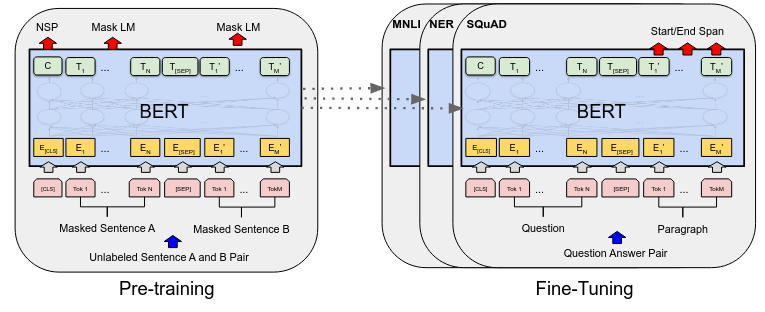

Transfer learning from large pre-trained models have shown be to effective in both NLP and CV landscapes

### MLM (Masked Language Modelling)


Randomly mask x% of the words in the sentence and make the model predict it(x = 15* in BERT). 

Note: The authors only consider the prediction of the masked words in their loss funciton and not the unmasked ones.

\* - Refer to the paper for elaborate details.

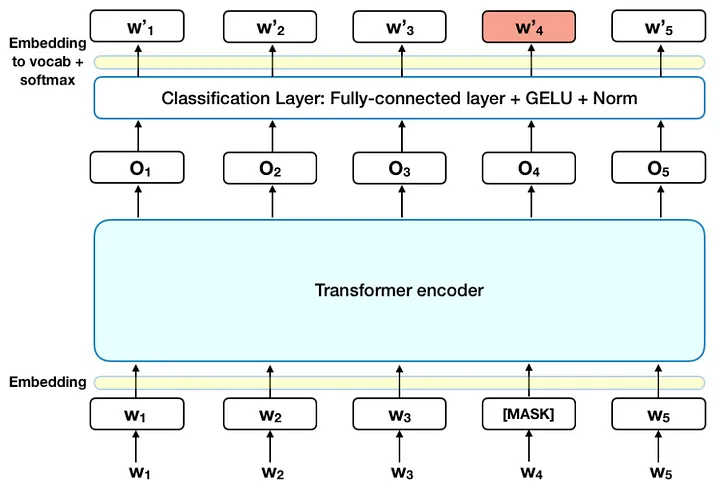

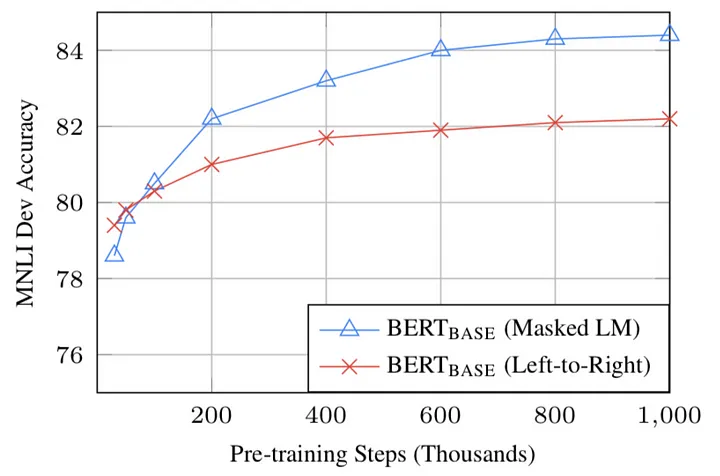

[source](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

### NSP

Given a pair of sentence <A,B> predict wheather B is the logical next sentence or not. During pre-training 50% of the time B is the subsequent next sentence from the corpus and the rest 50% of the time B is a random sentence from the corpus.

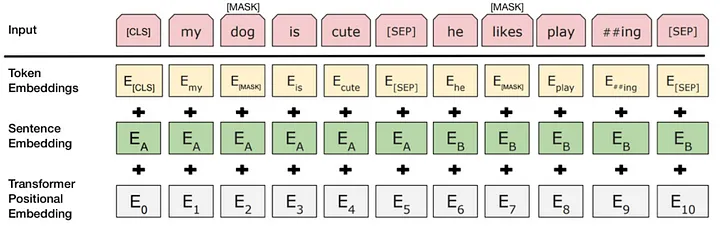

The output representation for [CLS] token is projected to (2,1) vector through a Linear layer and softmax is taken to decide if B is the next sentence or not.

### Fine-tuning

- It can be adapted to various tasks by simply adding the appropriate output layer.
  - Classification tasks like sentiment analysis can accomplished to taking the output representation of [CLS] token and using a linear layer + softmax on the representation.

  - NER tasks: Take output representation of all output vectors and use a linear + softmax layer to classifiy to number of entities you need.

### Coding Time !

In [ ]:
!pip install transformers # HuggingFace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.8 MB/s eta 0:00:00


#### Lets check HuggingFace API

https://huggingface.co/docs/transformers/model_doc/bert

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, BertLMHeadModel
import torch 

#### Task1: Load the BERT (bert base uncased) tokenizer

In [ ]:
bert_tokenizer  = BertTokenizer.from_pretrained('bert-base-uncased') 
bert_model      = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Task2: For any sentence with a masked word get its logits

In [ ]:
# fact_inf = ["The capital of France is [MASK]", 
#             "[MASK] is the current president of India.", 
#             "My cat has [MASK] legs."]

my_custom_sentence = "[MASK] is the current president of India."
inputs_batch =  bert_tokenizer(my_custom_sentence, return_tensors = "pt")   # Call the tonkenizer
logits = bert_model(**inputs_batch).logits             # Pass `input_batch` to the model and get logits
print(logits.shape)

torch.Size([1, 10, 30522])


In [ ]:
inputs_batch

{'input_ids': tensor([[ 101,  103, 2003, 1996, 2783, 2343, 1997, 2634, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

What does the logits size represent?

#### Task3: Find the logits corresponding to the mask token

In [ ]:
# bert_tokenizer.mask_token_id
mask_token_index =  torch.where(inputs_batch['input_ids'] == bert_tokenizer.mask_token_id)[1]
mask_token_logits = logits[0,mask_token_index,:]
print(mask_token_logits.shape)

torch.Size([1, 30522])


#### Task4: Find the indices of the maxiumum probablity in the logits

In [ ]:
top_3_tokens = torch.topk(mask_token_logits,3,dim=1).indices #argmax or topk 
print(top_3_tokens)

tensor([[2002, 2016, 5960]])


### Task 5: Decode a index back to word

In [ ]:
ind = 2002 # Anynumber between 1,30522
print(bert_tokenizer.decode([ind]))

he


### Final task: Replace the [MASK] with its corresponding prediction

In [ ]:
for ch_indx in top_3_tokens[0]:
    print(my_custom_sentence.replace(bert_tokenizer.mask_token, bert_tokenizer.decode([ch_indx])))

he is the current president of India.
she is the current president of India.
singh is the current president of India.


## GPT

- Proposed by OpenAI tema
- Decoder only
- Left-Right
- ChatGPT, GPT-4 are derivatives of the original paper

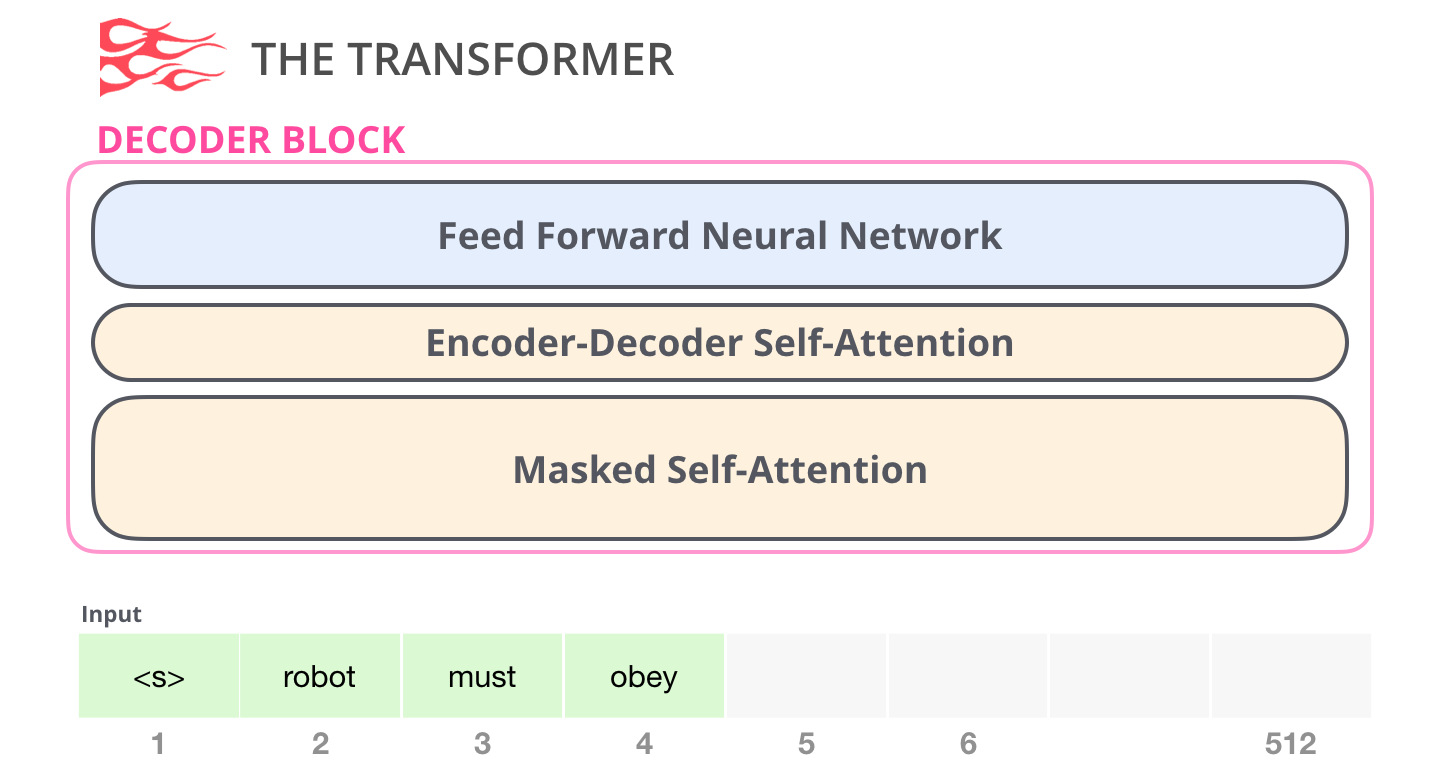

### Pre-Training

#### Snippet from the original paper
Learning Objective:

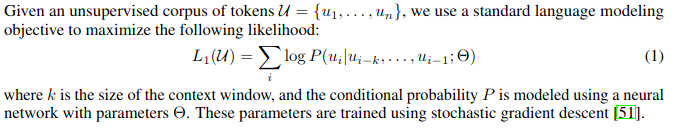

#### Fine-Tuning

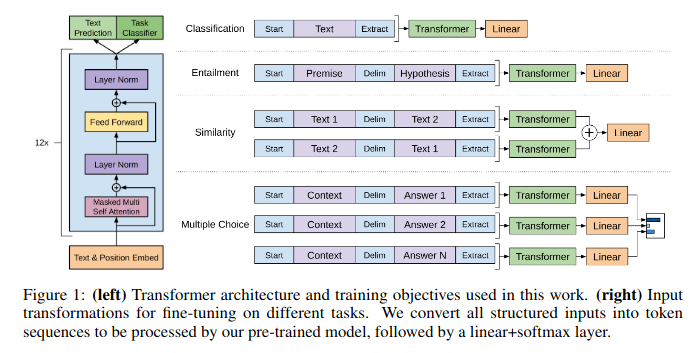

#### Lets code!

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Model
import torch 

#### Lets check HuggingFace API

https://huggingface.co/docs/transformers/model_doc/gpt2

##### Task1: Load GPT tokenizer and model

In [ ]:
gpt2_tokenizer  = GPT2Tokenizer.from_pretrained('gpt')
gpt2_model      = GPT2Model.from_pretrained('gpt')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

OSError: ignored

In [ ]:
text_generation_sentence = "The capital of France is"
inputs_batch = gpt2_tokenizer(text_generation_sentence,return_tensors = "pt")
generation_output = gpt2_model.generate(**inputs_batch, return_dict_in_generate=True, output_scores=True)
print(gpt2_tokenizer.batch_decode(generation_output.sequences))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['The capital of France is the capital of the French Republic, and the capital of the French Republic is']
